In [ ]:
# installling necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# more libraries to import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# making a checkpoint that saves the model when it gives the best accuracy on both sex and ADHD
class MultiMetricCheckpoint(Callback):
  def __init__(self, filepath, verbose=1):
    super().__init__()
    self.filepath = filepath
    self.verbose = verbose
    self.best_accuracy = -np.Inf

  def on_epoch_end(self, epoch, logs=None):
    sex_accuracy = logs.get('val_sex_accuracy')
    adhd_accuracy = logs.get('val_adhd_accuracy')
    mean_accuracy = (sex_accuracy + adhd_accuracy) / 2

    if mean_accuracy > self.best_accuracy:
      self.best_accuracy = mean_accuracy
      if self.verbose:
        print("New best model based on best accuracy, saved:")
      self.model.save(self.filepath)

In [ ]:
# loading the data files as paths
categorical_train = pd.read_excel("TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_train = pd.read_excel("TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_train = pd.read_csv("TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
solutions_train = pd.read_excel("TRAINING_SOLUTIONS.xlsx")

In [ ]:
# merging all the files using "participant_id" as the common variable
train_merged = connectome_train.merge(categorical_train, on="participant_id", how="inner")
train_merged = train_merged.merge(quantitative_train, on="participant_id", how="inner")
train_merged = train_merged.merge(solutions_train, on="participant_id", how="inner")

print("Shape of the merged df:", train_merged.shape)

Shape of the merged df: (544, 19930)


In [ ]:
# preprocessing
all_features_x = train_merged.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
targetvar_sex = train_merged['Sex_F']
targetvar_adhd = train_merged['ADHD_Outcome']

# impute and scale
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

x_features_imputer = imputer.fit_transform(all_features_x)
x_features_scaler = scaler.fit_transform(x_features_imputer)


In [ ]:
# splitting train-test data
x_train, x_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(x_features_scaler, targetvar_sex, targetvar_adhd, test_size=0.2, random_state=42, stratify=targetvar_adhd)

In [ ]:
from imblearn.over_sampling import SMOTE

# applying SMOTE to adhd training data
smote = SMOTE(random_state=42)
x_train_adhd_smote, y_train_adhd_smote = smote.fit_resample(x_train, y_train_adhd)

print("Status of class after SMOTE:")
print(pd.Series(y_train_adhd_smote).value_counts())


Status of class after SMOTE:
ADHD_Outcome
0    299
1    299
Name: count, dtype: int64


In [ ]:
# now since we have balanced the class imabalnce of ADHD, we're creating a SMOTE balanced model for ADHD alone

input_smote_layer = Input(shape=(x_train_adhd_smote.shape[1],))

hidden_smote_layer = Dense(64, activation='relu')(input_smote_layer)
hidden_smote_layer = Dropout(0.5)(hidden_smote_layer)
hidden_smote_layer = Dense(32, activation='relu')(hidden_smote_layer)

output_smote_layer = Dense(1, activation='sigmoid')(hidden_smote_layer)

adhd_model = Model(inputs=input_smote_layer, outputs=output_smote_layer)
adhd_model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

history_adhd = adhd_model.fit(x_train_adhd_smote,
                              y_train_adhd_smote,
                              validation_data = (x_val, y_val_adhd),
                              epochs=30,
                              batch_size=32,
                              verbose=2)

Epoch 1/30
19/19 - 2s - 123ms/step - accuracy: 0.6020 - loss: 1.5431 - val_accuracy: 0.6514 - val_loss: 1.4981
Epoch 2/30
19/19 - 1s - 27ms/step - accuracy: 0.8161 - loss: 0.8273 - val_accuracy: 0.6514 - val_loss: 1.8324
Epoch 3/30
19/19 - 0s - 25ms/step - accuracy: 0.8428 - loss: 0.6201 - val_accuracy: 0.6606 - val_loss: 1.9490
Epoch 4/30
19/19 - 1s - 27ms/step - accuracy: 0.9114 - loss: 0.3090 - val_accuracy: 0.6881 - val_loss: 2.1045
Epoch 5/30
19/19 - 0s - 23ms/step - accuracy: 0.9097 - loss: 0.3377 - val_accuracy: 0.6881 - val_loss: 2.1415
Epoch 6/30
19/19 - 1s - 34ms/step - accuracy: 0.9130 - loss: 0.3008 - val_accuracy: 0.6789 - val_loss: 2.4109
Epoch 7/30
19/19 - 1s - 32ms/step - accuracy: 0.9281 - loss: 0.2463 - val_accuracy: 0.6789 - val_loss: 2.6670
Epoch 8/30
19/19 - 1s - 34ms/step - accuracy: 0.9498 - loss: 0.1780 - val_accuracy: 0.6881 - val_loss: 2.5280
Epoch 9/30
19/19 - 1s - 33ms/step - accuracy: 0.9565 - loss: 0.1922 - val_accuracy: 0.6972 - val_loss: 2.6839
Epoch 10/

In [ ]:
results = adhd_model.evaluate(x_val, y_val_adhd, verbose=0)
print(f"\n ADHD-only model – Val Loss: {results[0]:.4f}, Val Accuracy: {results[1]:.4f}")



 ADHD-only model – Val Loss: 4.6367, Val Accuracy: 0.6881


In [ ]:
# modified multi-output neural network model

input_layer = Input(shape=(x_train.shape[1],))

common_layer = Dense(32, activation='relu')(input_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = Dropout(0.5)(common_layer)
common_layer = Dense(24, activation='relu')(common_layer)
common_layer = BatchNormalization()(common_layer)

# sex specific layers
sex_focused_layer = Dense(24, activation='relu')(common_layer)
#sex_focused_layer = BatchNormalization()(sex_focused_layer)
sex_focused_layer = Dropout(0.3)(sex_focused_layer)

output_sex_common_layer = Dense(1, activation='sigmoid', name='sex')(sex_focused_layer)

# adhd specific layers
adhd_focused_layer = Dense(24, activation='relu')(common_layer)
#adhd_focused_layer = BatchNormalization()(adhd_focused_layer)
adhd_focused_layer = Dropout(0.3)(adhd_focused_layer)

output_adhd_common_layer = Dense(1, activation='sigmoid', name='adhd')(adhd_focused_layer)

model = Model(inputs = input_layer, outputs = [output_sex_common_layer, output_adhd_common_layer])
model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-3),
              loss={'sex':'binary_crossentropy', 'adhd':'binary_crossentropy'},
              metrics={'sex':'accuracy', 'adhd':'accuracy'},
              loss_weights={'sex':2.0, 'adhd':2.0})


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

modif_checkpoint = ModelCheckpoint('best_performing_adhd.h5',
                                   monitor="val_adhd_accuracy",
                                   mode='max',
                                   save_best_only=True,
                                   verbose=1)

modif_earlystop = EarlyStopping(monitor="val_loss",
                                mode='min',
                                patience=5,
                                restore_best_weights=True,
                                verbose=1)

modif_reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# training the modified model

common_history = model.fit(x_train,
                    {'sex':y_train_sex, 'adhd':y_train_adhd},
                    validation_data = (x_val, {'sex':y_val_sex, 'adhd':y_val_adhd}),
                    epochs=30,
                    batch_size=32,
                    callbacks=[modif_checkpoint, modif_earlystop, modif_reducelr])

Epoch 1/30
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - adhd_accuracy: 0.4979 - adhd_loss: 0.7723 - loss: 3.1954 - sex_accuracy: 0.4617 - sex_loss: 0.8254
Epoch 1: val_adhd_accuracy improved from -inf to 0.45872, saving model to best_performing_adhd.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - adhd_accuracy: 0.5017 - adhd_loss: 0.7724 - loss: 3.2050 - sex_accuracy: 0.4591 - sex_loss: 0.8294 - val_adhd_accuracy: 0.4587 - val_adhd_loss: 0.7810 - val_loss: 3.1839 - val_sex_accuracy: 0.4037 - val_sex_loss: 0.7900 - learning_rate: 1.0000e-04
Epoch 2/30
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - adhd_accuracy: 0.5322 - adhd_loss: 0.7548 - loss: 3.0142 - sex_accuracy: 0.5552 - sex_loss: 0.7523
Epoch 2: val_adhd_accuracy did not improve from 0.45872
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - adhd_accuracy: 0.5329 - adhd_loss: 0.7517 - loss: 3.0113 - sex_accuracy: 0.5525 - sex_loss: 0.7547 - val_adhd_accuracy: 0.4587 - val_adhd_loss: 0.7662 - val_loss: 3.0922 - val_sex_accuracy: 0.4312 - val_sex_loss: 0.7578 - learning_rate: 1.0000e-04
Epoch 3/30
10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - adhd_accuracy: 0.5803 - adhd_loss: 0.7317 - loss: 2.9299 - sex_accuracy: 0.5210 - sex_loss: 0.7333
Epoch 3: val_adhd_accuracy improved from 0.45872 to 0.47706,

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - adhd_accuracy: 0.5799 - adhd_loss: 0.7274 - loss: 2.9298 - sex_accuracy: 0.5236 - sex_loss: 0.7372 - val_adhd_accuracy: 0.4771 - val_adhd_loss: 0.7553 - val_loss: 3.0108 - val_sex_accuracy: 0.4954 - val_sex_loss: 0.7347 - learning_rate: 1.0000e-04
Epoch 4/30
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - adhd_accuracy: 0.5437 - adhd_loss: 0.6911 - loss: 2.7726 - sex_accuracy: 0.6118 - sex_loss: 0.6952
Epoch 4: val_adhd_accuracy did not improve from 0.47706
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - adhd_accuracy: 0.5523 - adhd_loss: 0.6874 - loss: 2.7736 - sex_accuracy: 0.6040 - sex_loss: 0.6999 - val_adhd_accuracy: 0.4404 - val_adhd_loss: 0.7513 - val_loss: 2.9551 - val_sex_accuracy: 0.4954 - val_sex_loss: 0.7125 - learning_rate: 1.0000e-04
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - adhd_accuracy: 0.6248 - adhd_loss: 0.6523 - loss: 2.6853 - sex_accuracy: 0.5951 - sex_loss: 0.6901
Epoch 5: val_adhd_accuracy improved from 0.47706 to 0.48624,

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - adhd_accuracy: 0.6255 - adhd_loss: 0.6519 - loss: 2.6844 - sex_accuracy: 0.5948 - sex_loss: 0.6899 - val_adhd_accuracy: 0.4862 - val_adhd_loss: 0.7457 - val_loss: 2.9008 - val_sex_accuracy: 0.5046 - val_sex_loss: 0.6941 - learning_rate: 1.0000e-04
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - adhd_accuracy: 0.6580 - adhd_loss: 0.6309 - loss: 2.6184 - sex_accuracy: 0.5982 - sex_loss: 0.6783
Epoch 6: val_adhd_accuracy improved from 0.48624 to 0.52294, saving model to best_performing_adhd.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - adhd_accuracy: 0.6584 - adhd_loss: 0.6307 - loss: 2.6159 - sex_accuracy: 0.5981 - sex_loss: 0.6774 - val_adhd_accuracy: 0.5229 - val_adhd_loss: 0.7356 - val_loss: 2.8613 - val_sex_accuracy: 0.5505 - val_sex_loss: 0.6887 - learning_rate: 1.0000e-04
Epoch 7/30
10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - adhd_accuracy: 0.7469 - adhd_loss: 0.5708 - loss: 2.4377 - sex_accuracy: 0.6224 - sex_loss: 0.6481
Epoch 7: val_adhd_accuracy did not improve from 0.52294
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - adhd_accuracy: 0.7296 - adhd_loss: 0.5826 - loss: 2.4550 - sex_accuracy: 0.6261 - sex_loss: 0.6444 - val_adhd_accuracy: 0.5046 - val_adhd_loss: 0.7297 - val_loss: 2.8289 - val_sex_accuracy: 0.5321 - val_sex_loss: 0.6802 - learning_rate: 1.0000e-04
Epoch 8/30
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - adhd_accuracy: 0.7281 - adhd_loss: 0.5791 - loss: 2.3833 - sex_accuracy: 0.6725 - sex_loss: 0.6126
Epoch 8: val_adhd_accuracy improved from 0.52294 to 0.53211,

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - adhd_accuracy: 0.7206 - adhd_loss: 0.5812 - loss: 2.3838 - sex_accuracy: 0.6741 - sex_loss: 0.6113 - val_adhd_accuracy: 0.5321 - val_adhd_loss: 0.7248 - val_loss: 2.8094 - val_sex_accuracy: 0.4954 - val_sex_loss: 0.6764 - learning_rate: 1.0000e-04
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - adhd_accuracy: 0.6190 - adhd_loss: 0.6571 - loss: 2.5093 - sex_accuracy: 0.7099 - sex_loss: 0.5976
Epoch 9: val_adhd_accuracy improved from 0.53211 to 0.55046, saving model to best_performing_adhd.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - adhd_accuracy: 0.6223 - adhd_loss: 0.6542 - loss: 2.5048 - sex_accuracy: 0.7092 - sex_loss: 0.5982 - val_adhd_accuracy: 0.5505 - val_adhd_loss: 0.7151 - val_loss: 2.7527 - val_sex_accuracy: 0.5596 - val_sex_loss: 0.6597 - learning_rate: 1.0000e-04
Epoch 10/30
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - adhd_accuracy: 0.6355 - adhd_loss: 0.6319 - loss: 2.4992 - sex_accuracy: 0.6807 - sex_loss: 0.6177
Epoch 10: val_adhd_accuracy did not improve from 0.55046
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - adhd_accuracy: 0.6369 - adhd_loss: 0.6297 - loss: 2.4881 - sex_accuracy: 0.6847 - sex_loss: 0.6144 - val_adhd_accuracy: 0.5505 - val_adhd_loss: 0.7129 - val_loss: 2.7371 - val_sex_accuracy: 0.5872 - val_sex_loss: 0.6552 - learning_rate: 1.0000e-04
Epoch 11/30
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - adhd_accuracy: 0.7526 - adhd_loss: 0.5501 - loss: 2.2565 - sex_accuracy: 0.6781 - sex_loss: 0.5782
Epoch 11: val_adhd_accuracy improved from 0.55046 to 0.57

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - adhd_accuracy: 0.7497 - adhd_loss: 0.5512 - loss: 2.2593 - sex_accuracy: 0.6778 - sex_loss: 0.5791 - val_adhd_accuracy: 0.5780 - val_adhd_loss: 0.7103 - val_loss: 2.7142 - val_sex_accuracy: 0.5872 - val_sex_loss: 0.6479 - learning_rate: 1.0000e-04
Epoch 12/30
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - adhd_accuracy: 0.7456 - adhd_loss: 0.5549 - loss: 2.2349 - sex_accuracy: 0.7050 - sex_loss: 0.5626
Epoch 12: val_adhd_accuracy improved from 0.57798 to 0.59633, saving model to best_performing_adhd.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - adhd_accuracy: 0.7467 - adhd_loss: 0.5519 - loss: 2.2242 - sex_accuracy: 0.7088 - sex_loss: 0.5605 - val_adhd_accuracy: 0.5963 - val_adhd_loss: 0.7109 - val_loss: 2.7166 - val_sex_accuracy: 0.6055 - val_sex_loss: 0.6457 - learning_rate: 1.0000e-04
Epoch 13/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - adhd_accuracy: 0.7366 - adhd_loss: 0.5445 - loss: 2.1666 - sex_accuracy: 0.7526 - sex_loss: 0.5386
Epoch 13: val_adhd_accuracy did not improve from 0.59633
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - adhd_accuracy: 0.7359 - adhd_loss: 0.5448 - loss: 2.1673 - sex_accuracy: 0.7523 - sex_loss: 0.5383 - val_adhd_accuracy: 0.5872 - val_adhd_loss: 0.6973 - val_loss: 2.6711 - val_sex_accuracy: 0.6239 - val_sex_loss: 0.6419 - learning_rate: 1.0000e-04
Epoch 14/30
12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - adhd_accuracy: 0.7442 - adhd_loss: 0.5440 - loss: 2.2159 - sex_accuracy: 0.6999 - sex_loss: 0.5640
Epoch 14: val_adhd_accuracy improved from 0.59633 to 0.64

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - adhd_accuracy: 0.7453 - adhd_loss: 0.5437 - loss: 2.2123 - sex_accuracy: 0.7014 - sex_loss: 0.5627 - val_adhd_accuracy: 0.6422 - val_adhd_loss: 0.6899 - val_loss: 2.6324 - val_sex_accuracy: 0.5963 - val_sex_loss: 0.6337 - learning_rate: 1.0000e-04
Epoch 15/30
10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - adhd_accuracy: 0.7359 - adhd_loss: 0.5347 - loss: 2.1796 - sex_accuracy: 0.6848 - sex_loss: 0.5551
Epoch 15: val_adhd_accuracy did not improve from 0.64220
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - adhd_accuracy: 0.7399 - adhd_loss: 0.5322 - loss: 2.1723 - sex_accuracy: 0.6952 - sex_loss: 0.5539 - val_adhd_accuracy: 0.6330 - val_adhd_loss: 0.6891 - val_loss: 2.6227 - val_sex_accuracy: 0.6147 - val_sex_loss: 0.6263 - learning_rate: 1.0000e-04
Epoch 16/30
10/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - adhd_accuracy: 0.8114 - adhd_loss: 0.5084 - loss: 2.1727 - sex_accuracy: 0.7294 - sex_loss: 0.5780
Epoch 16: val_adhd_accuracy did not improve from 0.64220


In [ ]:
# saving the best model predictions

from tensorflow.keras.models import load_model

best_model = load_model('best_performing_adhd.h5')

sex_prediction, adhd_prediction = best_model.predict(x_val)

binary_sex_prediction = (sex_prediction > 0.5).astype(int).flatten()
binary_adhd_prediction = (adhd_prediction > 0.5).astype(int).flatten()

participant_ids = x_val.index if hasattr(x_val, 'index') else range(len(x_val))

final_predictions_df = pd.DataFrame({
    'participant_id': participant_ids,
    'Sex_F': binary_sex_prediction,
    'ADHD_Outcome': binary_adhd_prediction
})

# saving predictions to a cvs file
final_predictions_df.to_csv('final_predictions.csv', index=False)
print("Predictions saved to 'final_predictions.csv'")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predictions saved to 'final_predictions.csv'


In [ ]:
# printing out modified model results
model_results = model.evaluate(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}, verbose=0)

print("----- Evaluation Metrics (Manual) -----")
print(f"Total loss:      {model_results[0]:.4f}")
print(f"Sex loss:        {model_results[1]:.4f}")
print(f"ADHD loss:       {model_results[2]:.4f}")
print(f"Sex accuracy:    {model_results[3]:.4f}")
print(f"ADHD accuracy:   {model_results[4]:.4f}")

----- Evaluation Metrics (Manual) -----
Total loss:      2.5056
Sex loss:        0.6001
ADHD loss:       0.6681
Sex accuracy:    0.6055
ADHD accuracy:   0.7064


In [ ]:
best_val_sex_accuracy = max(common_history.history['val_sex_accuracy'])
print("Best validation sex accuracy:", best_val_sex_accuracy)

best_val_adhd_accuracy = max(common_history.history['val_adhd_accuracy'])
print("Best validation ADHD accuracy:", best_val_adhd_accuracy)

Best validation sex accuracy: 0.7339449524879456
Best validation ADHD accuracy: 0.642201840877533


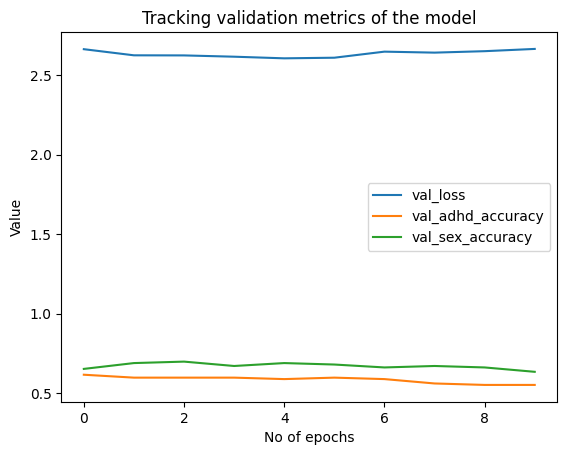

In [ ]:
# plotting the 3 metrics- val_loss, val_adhd_accuracy and val_sex_accuracy to trakc them

main_metrics = ['val_loss', 'val_adhd_accuracy', 'val_sex_accuracy']
for m in main_metrics:
  plt.plot(common_history.history[m], label=m)

plt.xlabel("No of epochs")
plt.ylabel("Value")
plt.title("Tracking validation metrics of the model")
plt.legend()
plt.show()

In [ ]:
# old
# making the multi-output neural network
input_layer = Input(shape=(x_train.shape[1],))

#hidden_layer = Dense(64, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01))(input_layer)
hidden_layer = Dense(64, activation='relu')(input_layer)
hidden_layer = Dropout(0.5)(hidden_layer)
hidden_layer = Dense(32, activation='relu')(hidden_layer)

output_sex_layer = Dense(1, activation='sigmoid', name='sex')(hidden_layer)
output_adhd_layer = Dense(1, activation='sigmoid', name='adhd')(hidden_layer)

model = Model(inputs = input_layer, outputs = [output_sex_layer, output_adhd_layer])
model.compile(optimizer=Adam(1e-3), loss={'sex':'binary_crossentropy', 'adhd':'binary_crossentropy'}, metrics={'sex':'accuracy', 'adhd':'accuracy'}, loss_weights={'sex':1.0, 'adhd':2.0})

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 19927)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │  1,275,392 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sex (Dense)         │ (None, 1)         │         33 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adhd (Dense)        │ (None, 1)         │         33 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,277,538 (4.87 MB)

 Trainable params: 1,277,538 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#old
# training the model
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(x_train,
                    {'sex':y_train_sex, 'adhd':y_train_adhd},
                    validation_data = (x_val, {'sex':y_val_sex, 'adhd':y_val_adhd}),
                    epochs=50,
                    batch_size=32,
                    callbacks=[es])

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - adhd_accuracy: 0.5671 - adhd_loss: 1.2226 - loss: 3.6459 - sex_accuracy: 0.5544 - sex_loss: 1.2011 - val_adhd_accuracy: 0.5473 - val_adhd_loss: 1.3692 - val_loss: 3.7111 - val_sex_accuracy: 0.6626 - val_sex_loss: 0.9627
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - adhd_accuracy: 0.7148 - adhd_loss: 0.9965 - loss: 3.2225 - sex_accuracy: 0.6658 - sex_loss: 1.2326 - val_adhd_accuracy: 0.5638 - val_adhd_loss: 1.2713 - val_loss: 3.2933 - val_sex_accuracy: 0.7037 - val_sex_loss: 0.7657
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - adhd_accuracy: 0.7820 - adhd_loss: 0.7909 - loss: 2.4950 - sex_accuracy: 0.7360 - sex_loss: 0.9122 - val_adhd_accuracy: 0.5844 - val_adhd_loss: 1.2036 - val_loss: 3.3718 - val_sex_accuracy: 0.6790 - val_sex_loss: 1.0001
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - adhd_accuracy: 0.7982 - adhd_loss: 0.7581 - loss: 2.4521 - sex_accuracy: 0.7359 - sex_loss: 0.9356 - val_adhd_accuracy: 0.5802 -

In [ ]:
# old
model_results = model.evaluate(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}, verbose=0)

print("----- Evaluation Metrics (Manual) -----")
print(f"Total loss:      {model_results[0]:.4f}")
print(f"Sex loss:        {model_results[1]:.4f}")
print(f"ADHD loss:       {model_results[2]:.4f}")
print(f"Sex accuracy:    {model_results[3]:.4f}")
print(f"ADHD accuracy:   {model_results[4]:.4f}")

#for name, value in zip(model.metrics_names, model_results):
    #print(f"{name}: {value:.4f}")

----- Evaluation Metrics (Manual) -----
Total loss:      3.2850
Sex loss:        0.7929
ADHD loss:       1.2422
Sex accuracy:    0.6255
ADHD accuracy:   0.6955


Tried improving the model accuracy-Noureen


Shape of the merged df: (153, 19930)
Status of class after SMOTE:
ADHD_Outcome
1    89
0    89
Name: count, dtype: int64
Epoch 1/30
6/6 - 3s - 553ms/step - accuracy: 0.5899 - loss: 3.7917 - val_accuracy: 0.5806 - val_loss: 4.8253
Epoch 2/30
6/6 - 1s - 109ms/step - accuracy: 0.8539 - loss: 3.0904 - val_accuracy: 0.6452 - val_loss: 5.1375
Epoch 3/30
6/6 - 1s - 93ms/step - accuracy: 0.9270 - loss: 3.0339 - val_accuracy: 0.6774 - val_loss: 5.4551
Epoch 4/30
6/6 - 1s - 87ms/step - accuracy: 0.9551 - loss: 2.9849 - val_accuracy: 0.6774 - val_loss: 5.7822
Epoch 5/30
6/6 - 0s - 80ms/step - accuracy: 0.9663 - loss: 3.1103 - val_accuracy: 0.6129 - val_loss: 6.7874
Epoch 6/30
6/6 - 1s - 100ms/step - accuracy: 0.9663 - loss: 2.9671 - val_accuracy: 0.6129 - val_loss: 8.6253
Epoch 7/30
6/6 - 0s - 74ms/step - accuracy: 0.9663 - loss: 2.9663 - val_accuracy: 0.5806 - val_loss: 7.8162
Epoch 8/30
6/6 - 1s - 116ms/step - accuracy: 0.9775 - loss: 2.8032 - val_accuracy: 0.5806 - val_loss: 7.3631
Epoch 9/30


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - adhd_accuracy: 0.5218 - adhd_loss: 0.7749 - loss: 5.6299 - sex_accuracy: 0.5066 - sex_loss: 0.9479 - val_adhd_accuracy: 0.6452 - val_adhd_loss: 1.1156 - val_loss: 8.5190 - val_sex_accuracy: 0.6129 - val_sex_loss: 2.0869 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - adhd_accuracy: 0.5997 - adhd_loss: 0.7518 - loss: 5.0459 - sex_accuracy: 0.7607 - sex_loss: 0.6084
Epoch 2: val_adhd_accuracy did not improve from 0.64516
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - adhd_accuracy: 0.6044 - adhd_loss: 0.7442 - loss: 5.0389 - sex_accuracy: 0.7577 - sex_loss: 0.6077 - val_adhd_accuracy: 0.6129 - val_adhd_loss: 1.1909 - val_loss: 9.1580 - val_sex_accuracy: 0.6129 - val_sex_loss: 2.2737 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - adhd_accuracy: 0.6708 - adhd_loss: 0.6592 - loss: 4.7786 - sex_accuracy: 0.8262 - sex_loss: 0.4707
Epoch 3: val_adhd_accuracy did not improve from 0.64516
4/4 ━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - adhd_accuracy: 0.7341 - adhd_loss: 0.5469 - loss: 4.7559 - sex_accuracy: 0.7719 - sex_loss: 0.4464 - val_adhd_accuracy: 0.6774 - val_adhd_loss: 0.8021 - val_loss: 6.8058 - val_sex_accuracy: 0.6129 - val_sex_loss: 1.2574 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - adhd_accuracy: 0.7795 - adhd_loss: 0.4847 - loss: 4.6147 - sex_accuracy: 0.8550 - sex_loss: 0.3969
Epoch 6: val_adhd_accuracy did not improve from 0.67742
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - adhd_accuracy: 0.7711 - adhd_loss: 0.4957 - loss: 4.6251 - sex_accuracy: 0.8545 - sex_loss: 0.3934 - val_adhd_accuracy: 0.6774 - val_adhd_loss: 0.7640 - val_loss: 6.4332 - val_sex_accuracy: 0.6452 - val_sex_loss: 1.0866 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - adhd_accuracy: 0.7233 - adhd_loss: 0.5280 - loss: 4.7564 - sex_accuracy: 0.8418 - sex_loss: 0.4226
Epoch 7: val_adhd_accuracy did not improve from 0.67742
4/4 ━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - adhd_accuracy: 0.9714 - adhd_loss: 0.1229 - loss: 1.5720 - sex_accuracy: 0.9915 - sex_loss: 0.0581 - val_adhd_accuracy: 0.7097 - val_adhd_loss: 0.6993 - val_loss: 3.6869 - val_sex_accuracy: 0.6774 - val_sex_loss: 0.6995 - learning_rate: 0.0010
Epoch 44/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - adhd_accuracy: 0.9587 - adhd_loss: 0.1490 - loss: 1.5901 - sex_accuracy: 0.9808 - sex_loss: 0.0671
Epoch 44: val_adhd_accuracy did not improve from 0.70968
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - adhd_accuracy: 0.9620 - adhd_loss: 0.1438 - loss: 1.5805 - sex_accuracy: 0.9797 - sex_loss: 0.0667 - val_adhd_accuracy: 0.6774 - val_adhd_loss: 0.7142 - val_loss: 3.6843 - val_sex_accuracy: 0.6774 - val_sex_loss: 0.7066 - learning_rate: 0.0010
Epoch 45/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - adhd_accuracy: 0.9953 - adhd_loss: 0.1060 - loss: 1.5122 - sex_accuracy: 0.9836 - sex_loss: 0.0801
Epoch 45: val_adhd_accuracy did not improve from 0.70968
4/4 ━━━━━━━━━━

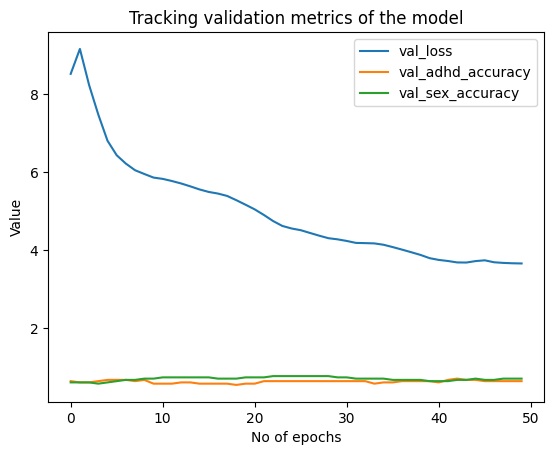

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# --- Data Loading and Merging ---
categorical_train = pd.read_excel("TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_train = pd.read_excel("TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_train = pd.read_csv("TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
solutions_train = pd.read_excel("TRAINING_SOLUTIONS.xlsx")

# Merging the datasets on 'participant_id'
train_merged = connectome_train.merge(categorical_train, on="participant_id", how="inner")
train_merged = train_merged.merge(quantitative_train, on="participant_id", how="inner")
train_merged = train_merged.merge(solutions_train, on="participant_id", how="inner")

print("Shape of the merged df:", train_merged.shape)

# --- Preprocessing ---
all_features_x = train_merged.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
targetvar_sex = train_merged['Sex_F']
targetvar_adhd = train_merged['ADHD_Outcome']

# Impute missing values and scale features
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

x_features_imputer = imputer.fit_transform(all_features_x)
x_features_scaler = scaler.fit_transform(x_features_imputer)

# Splitting into train and validation sets
x_train, x_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(
    x_features_scaler, targetvar_sex, targetvar_adhd, test_size=0.2, random_state=42, stratify=targetvar_adhd)

# --- Handle Class Imbalance using SMOTE ---
smote = SMOTE(random_state=42)
x_train_adhd_smote, y_train_adhd_smote = smote.fit_resample(x_train, y_train_adhd)

print("Status of class after SMOTE:")
print(pd.Series(y_train_adhd_smote).value_counts())

# --- ADHD-only Model ---
input_smote_layer = Input(shape=(x_train_adhd_smote.shape[1],))

hidden_smote_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_smote_layer)  # Increased units
hidden_smote_layer = Dropout(0.5)(hidden_smote_layer)
hidden_smote_layer = Dense(64, activation='relu')(hidden_smote_layer)

output_smote_layer = Dense(1, activation='sigmoid')(hidden_smote_layer)

adhd_model = Model(inputs=input_smote_layer, outputs=output_smote_layer)
adhd_model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Training ADHD-only model
history_adhd = adhd_model.fit(x_train_adhd_smote,
                              y_train_adhd_smote,
                              validation_data=(x_val, y_val_adhd),
                              epochs=30,
                              batch_size=32,
                              verbose=2)

results = adhd_model.evaluate(x_val, y_val_adhd, verbose=0)
print(f"\nADHD-only model – Val Loss: {results[0]:.4f}, Val Accuracy: {results[1]:.4f}")

# --- Multi-output Model (Sex_F and ADHD) ---
input_layer = Input(shape=(x_train.shape[1],))

# Common layers
common_layer = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = Dropout(0.5)(common_layer)
common_layer = Dense(64, activation='relu')(common_layer)
common_layer = BatchNormalization()(common_layer)

# Sex-specific layers
sex_focused_layer = Dense(16, activation='relu')(common_layer)
sex_focused_layer = Dropout(0.3)(sex_focused_layer)
output_sex_layer = Dense(1, activation='sigmoid', name='sex')(sex_focused_layer)

# ADHD-specific layers
adhd_focused_layer = Dense(16, activation='relu')(common_layer)
adhd_focused_layer = Dropout(0.3)(adhd_focused_layer)
output_adhd_layer = Dense(1, activation='sigmoid', name='adhd')(adhd_focused_layer)

# Final model
model = Model(inputs=input_layer, outputs=[output_sex_layer, output_adhd_layer])

# Compile the model with AdamW optimizer and learning rate scheduler
optimizer = Adam(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer,
              loss={'sex': 'binary_crossentropy', 'adhd': 'binary_crossentropy'},
              metrics={'sex': 'accuracy', 'adhd': 'accuracy'},
              loss_weights={'sex': 2.0, 'adhd': 1.5})

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping and model checkpoint
modif_checkpoint = ModelCheckpoint('best_performing_adhd.h5',
                                   monitor="val_adhd_accuracy",
                                   mode='max',
                                   save_best_only=True,
                                   verbose=1)

modif_earlystop = EarlyStopping(monitor="val_loss",
                                mode='min',
                                patience=5,
                                restore_best_weights=True,
                                verbose=1)

# Training the multi-output model
common_history = model.fit(x_train,
                           {'sex': y_train_sex, 'adhd': y_train_adhd},
                           validation_data=(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}),
                           epochs=50,
                           batch_size=32,
                           callbacks=[modif_checkpoint, modif_earlystop, lr_scheduler])

# Evaluation of the model
model_results = model.evaluate(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}, verbose=0)

print("----- Evaluation Metrics (Manual) -----")
print(f"Total loss:      {model_results[0]:.4f}")
print(f"Sex loss:        {model_results[1]:.4f}")
print(f"ADHD loss:       {model_results[2]:.4f}")
print(f"Sex accuracy:    {model_results[3]:.4f}")
print(f"ADHD accuracy:   {model_results[4]:.4f}")

best_val_sex_accuracy = max(common_history.history['val_sex_accuracy'])
print("Best validation sex accuracy:", best_val_sex_accuracy)

best_val_adhd_accuracy = max(common_history.history['val_adhd_accuracy'])
print("Best validation ADHD accuracy:", best_val_adhd_accuracy)

# Plotting the metrics (val_loss, val_adhd_accuracy, val_sex_accuracy)
main_metrics = ['val_loss', 'val_adhd_accuracy', 'val_sex_accuracy']
for m in main_metrics:
    plt.plot(common_history.history[m], label=m)

plt.xlabel("No of epochs")
plt.ylabel("Value")
plt.title("Tracking validation metrics of the model")
plt.legend()
plt.show()


Shape of the merged df: (1213, 19930)
Status of class after SMOTE:
ADHD_Outcome
1    665
0    665
Name: count, dtype: int64
Epoch 1/50
42/42 - 10s - 238ms/step - accuracy: 0.6271 - loss: 6.3405 - val_accuracy: 0.5185 - val_loss: 6.2447
Epoch 2/50
42/42 - 4s - 85ms/step - accuracy: 0.7361 - loss: 4.9304 - val_accuracy: 0.5967 - val_loss: 4.3140
Epoch 3/50
42/42 - 4s - 87ms/step - accuracy: 0.8173 - loss: 3.3062 - val_accuracy: 0.6008 - val_loss: 3.1322
Epoch 4/50
42/42 - 5s - 117ms/step - accuracy: 0.8481 - loss: 2.4081 - val_accuracy: 0.6420 - val_loss: 2.6363
Epoch 5/50
42/42 - 3s - 83ms/step - accuracy: 0.8579 - loss: 2.0079 - val_accuracy: 0.6626 - val_loss: 2.3784
Epoch 6/50
42/42 - 6s - 133ms/step - accuracy: 0.8842 - loss: 1.7564 - val_accuracy: 0.6379 - val_loss: 2.3116
Epoch 7/50
42/42 - 6s - 140ms/step - accuracy: 0.8820 - loss: 1.6956 - val_accuracy: 0.6667 - val_loss: 2.3036
Epoch 8/50
42/42 - 4s - 103ms/step - accuracy: 0.8654 - loss: 1.7413 - val_accuracy: 0.6420 - val_los

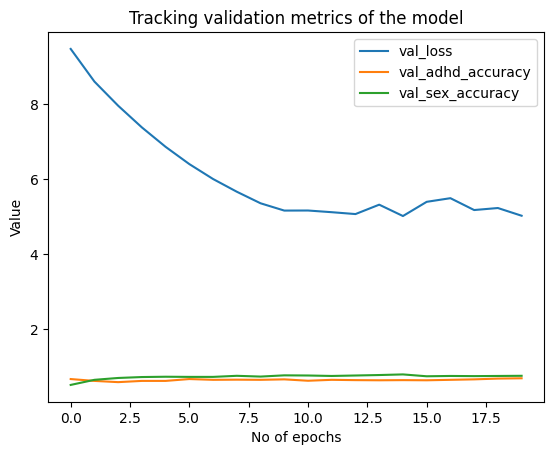

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# --- Data Loading and Merging ---
categorical_train = pd.read_excel("TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_train = pd.read_excel("TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_train = pd.read_csv("TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
solutions_train = pd.read_excel("TRAINING_SOLUTIONS.xlsx")

# Merging the datasets on 'participant_id'
train_merged = connectome_train.merge(categorical_train, on="participant_id", how="inner")
train_merged = train_merged.merge(quantitative_train, on="participant_id", how="inner")
train_merged = train_merged.merge(solutions_train, on="participant_id", how="inner")

print("Shape of the merged df:", train_merged.shape)

# --- Preprocessing ---
all_features_x = train_merged.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
targetvar_sex = train_merged['Sex_F']
targetvar_adhd = train_merged['ADHD_Outcome']

# Impute missing values and scale features
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

x_features_imputer = imputer.fit_transform(all_features_x)
x_features_scaler = scaler.fit_transform(x_features_imputer)

# Splitting into train and validation sets
x_train, x_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(
    x_features_scaler, targetvar_sex, targetvar_adhd, test_size=0.2, random_state=42, stratify=targetvar_adhd)

# --- Handle Class Imbalance using SMOTE ---
smote = SMOTE(random_state=42)
x_train_adhd_smote, y_train_adhd_smote = smote.fit_resample(x_train, y_train_adhd)

print("Status of class after SMOTE:")
print(pd.Series(y_train_adhd_smote).value_counts())

# --- ADHD-only Model ---
input_smote_layer = Input(shape=(x_train_adhd_smote.shape[1],))

# Increase the number of layers and units
hidden_smote_layer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_smote_layer)  # Increased units
hidden_smote_layer = BatchNormalization()(hidden_smote_layer)  # BatchNormalization added for stability
hidden_smote_layer = Dropout(0.6)(hidden_smote_layer)  # Increased dropout
hidden_smote_layer = Dense(128, activation='relu')(hidden_smote_layer)  # More hidden units
hidden_smote_layer = BatchNormalization()(hidden_smote_layer)
hidden_smote_layer = Dropout(0.5)(hidden_smote_layer)

output_smote_layer = Dense(1, activation='sigmoid')(hidden_smote_layer)

adhd_model = Model(inputs=input_smote_layer, outputs=output_smote_layer)
adhd_model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Training ADHD-only model
history_adhd = adhd_model.fit(x_train_adhd_smote,
                              y_train_adhd_smote,
                              validation_data=(x_val, y_val_adhd),
                              epochs=50,
                              batch_size=32,
                              verbose=2)

results = adhd_model.evaluate(x_val, y_val_adhd, verbose=0)
print(f"\nADHD-only model – Val Loss: {results[0]:.4f}, Val Accuracy: {results[1]:.4f}")

# --- Multi-output Model (Sex_F and ADHD) ---
input_layer = Input(shape=(x_train.shape[1],))

# Common layers
common_layer = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = Dropout(0.5)(common_layer)
common_layer = Dense(128, activation='relu')(common_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = Dropout(0.5)(common_layer)

# Sex-specific layers
sex_focused_layer = Dense(64, activation='relu')(common_layer)
sex_focused_layer = Dropout(0.4)(sex_focused_layer)
output_sex_layer = Dense(1, activation='sigmoid', name='sex')(sex_focused_layer)

# ADHD-specific layers
adhd_focused_layer = Dense(64, activation='relu')(common_layer)
adhd_focused_layer = Dropout(0.4)(adhd_focused_layer)
output_adhd_layer = Dense(1, activation='sigmoid', name='adhd')(adhd_focused_layer)

# Final model
model = Model(inputs=input_layer, outputs=[output_sex_layer, output_adhd_layer])

# Compile the model with AdamW optimizer and learning rate scheduler
optimizer = Adam(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer,
              loss={'sex': 'binary_crossentropy', 'adhd': 'binary_crossentropy'},
              metrics={'sex': 'accuracy', 'adhd': 'accuracy'},
              loss_weights={'sex': 2.0, 'adhd': 1.5})

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping and model checkpoint
modif_checkpoint = ModelCheckpoint('best_performing_adhd.keras',
                                   monitor="val_adhd_accuracy",
                                   mode='max',
                                   save_best_only=True,
                                   verbose=1)

modif_earlystop = EarlyStopping(monitor="val_loss",
                                mode='min',
                                patience=5,
                                restore_best_weights=True,
                                verbose=1)

# Training the multi-output model
common_history = model.fit(x_train,
                           {'sex': y_train_sex, 'adhd': y_train_adhd},
                           validation_data=(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}),
                           epochs=50,
                           batch_size=32,
                           callbacks=[modif_checkpoint, modif_earlystop, lr_scheduler])

# Evaluation of the model
model_results = model.evaluate(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}, verbose=0)

print("----- Evaluation Metrics (Manual) -----")
print(f"Total loss:      {model_results[0]:.4f}")
print(f"Sex loss:        {model_results[1]:.4f}")
print(f"ADHD loss:       {model_results[2]:.4f}")
print(f"Sex accuracy:    {model_results[3]:.4f}")
print(f"ADHD accuracy:   {model_results[4]:.4f}")

best_val_sex_accuracy = max(common_history.history['val_sex_accuracy'])
print("Best validation sex accuracy:", best_val_sex_accuracy)

best_val_adhd_accuracy = max(common_history.history['val_adhd_accuracy'])
print("Best validation ADHD accuracy:", best_val_adhd_accuracy)

# Plotting the metrics (val_loss, val_adhd_accuracy, val_sex_accuracy)
main_metrics = ['val_loss', 'val_adhd_accuracy', 'val_sex_accuracy']
for m in main_metrics:
    plt.plot(common_history.history[m], label=m)

plt.xlabel("No of epochs")
plt.ylabel("Value")
plt.title("Tracking validation metrics of the model")
plt.legend()
plt.show()


added by tanya but not working

In [ ]:
# saving this model

from tensorflow.keras.models import load_model

best_model = load_model('best_performing_adhd.keras')
best_model.save('best_adhdsex_model.keras')

ValueError: File not found: filepath=best_performing_adhd.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# saving this model

pred_good = good_model.predict(x_val)
g_sex_pred = (pred_good[0] > 0.5).astype(int)
g_adhd_pred = (pred_good[1] > 0.5).astype(int)

g_pred_df = pd.DataFrame({'real_sex':y_val_sex.flatten(), 'good_sex_pred': g_sex_pred,
                          'real_adhd':y_val_adhd.flatten(), 'good_adhd_pred': g_adhd_pred})
g_pred_df.to_csv('good_model_predictions.csv', index=False)

NameError: name 'good_model' is not defined

Shape of the merged df: (1213, 19930)
Status of class after SMOTE:
ADHD_Outcome
1    665
0    665
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
21/21 - 12s - 571ms/step - accuracy: 0.6173 - loss: 9.8971 - val_accuracy: 0.5638 - val_loss: 8.8752 - learning_rate: 1.0000e-03
Epoch 2/100
21/21 - 15s - 732ms/step - accuracy: 0.7812 - loss: 5.8547 - val_accuracy: 0.5802 - val_loss: 4.5288 - learning_rate: 1.0000e-03
Epoch 3/100
21/21 - 13s - 635ms/step - accuracy: 0.8632 - loss: 2.7629 - val_accuracy: 0.5885 - val_loss: 2.7087 - learning_rate: 1.0000e-03
Epoch 4/100
21/21 - 7s - 316ms/step - accuracy: 0.9008 - loss: 1.6746 - val_accuracy: 0.5926 - val_loss: 2.2312 - learning_rate: 1.0000e-03
Epoch 5/100
21/21 - 10s - 498ms/step - accuracy: 0.8729 - loss: 1.6425 - val_accuracy: 0.5844 - val_loss: 2.6290 - learning_rate: 1.0000e-03
Epoch 6/100
21/21 - 10s - 482ms/step - accuracy: 0.8774 - loss: 1.7998 - val_accuracy: 0.5720 - val_loss: 2.7136 - learning_rate: 1.0000e-03
Epoch 7/100
21/21 - 8s - 402ms/step - accuracy: 0.8684 - loss: 1.7437 - val_accuracy: 0.6091 - val_loss: 2.5647 - learning_rate: 1.0000e-03
Epoch 8/100
21/

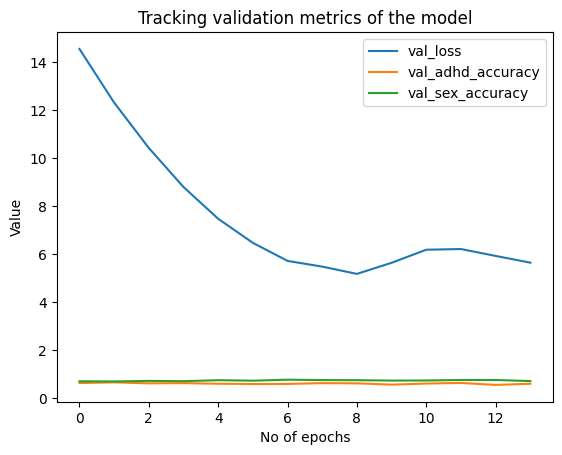

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# --- Data Loading and Merging ---
categorical_train = pd.read_excel("TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_train = pd.read_excel("TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_train = pd.read_csv("TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
solutions_train = pd.read_excel("TRAINING_SOLUTIONS.xlsx")

# Merging the datasets on 'participant_id'
train_merged = connectome_train.merge(categorical_train, on="participant_id", how="inner")
train_merged = train_merged.merge(quantitative_train, on="participant_id", how="inner")
train_merged = train_merged.merge(solutions_train, on="participant_id", how="inner")

print("Shape of the merged df:", train_merged.shape)

# --- Preprocessing ---
all_features_x = train_merged.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
targetvar_sex = train_merged['Sex_F']
targetvar_adhd = train_merged['ADHD_Outcome']

# Impute missing values and scale features
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

x_features_imputer = imputer.fit_transform(all_features_x)
x_features_scaler = scaler.fit_transform(x_features_imputer)

# Splitting into train and validation sets
x_train, x_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(
    x_features_scaler, targetvar_sex, targetvar_adhd, test_size=0.2, random_state=42, stratify=targetvar_adhd)

# --- Handle Class Imbalance using SMOTE ---
smote = SMOTE(random_state=42)
x_train_adhd_smote, y_train_adhd_smote = smote.fit_resample(x_train, y_train_adhd)

print("Status of class after SMOTE:")
print(pd.Series(y_train_adhd_smote).value_counts())

# --- ADHD-only Model ---
input_smote_layer = Input(shape=(x_train_adhd_smote.shape[1],))

# Increased hidden units, LeakyReLU, more Dropout, and BatchNormalization
hidden_smote_layer = Dense(512, kernel_regularizer=regularizers.l2(0.01))(input_smote_layer)  # Increased units
hidden_smote_layer = BatchNormalization()(hidden_smote_layer)
hidden_smote_layer = LeakyReLU(alpha=0.2)(hidden_smote_layer)  # LeakyReLU added for better gradient flow
hidden_smote_layer = Dropout(0.7)(hidden_smote_layer)  # Increased dropout
hidden_smote_layer = Dense(256)(hidden_smote_layer)
hidden_smote_layer = BatchNormalization()(hidden_smote_layer)
hidden_smote_layer = LeakyReLU(alpha=0.2)(hidden_smote_layer)
hidden_smote_layer = Dropout(0.5)(hidden_smote_layer)

output_smote_layer = Dense(1, activation='sigmoid')(hidden_smote_layer)

adhd_model = Model(inputs=input_smote_layer, outputs=output_smote_layer)
adhd_model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Training ADHD-only model
history_adhd = adhd_model.fit(x_train_adhd_smote,
                              y_train_adhd_smote,
                              validation_data=(x_val, y_val_adhd),
                              epochs=100,
                              batch_size=64,
                              verbose=2,
                              callbacks=[EarlyStopping(patience=10, restore_best_weights=True),
                                         ReduceLROnPlateau(factor=0.5, patience=5)])

results = adhd_model.evaluate(x_val, y_val_adhd, verbose=0)
print(f"\nADHD-only model – Val Loss: {results[0]:.4f}, Val Accuracy: {results[1]:.4f}")

# --- Multi-output Model (Sex_F and ADHD) ---
input_layer = Input(shape=(x_train.shape[1],))

# Common layers
common_layer = Dense(512, kernel_regularizer=regularizers.l2(0.01))(input_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = LeakyReLU(alpha=0.2)(common_layer)
common_layer = Dropout(0.6)(common_layer)
common_layer = Dense(256)(common_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = LeakyReLU(alpha=0.2)(common_layer)
common_layer = Dropout(0.5)(common_layer)

# Sex-specific layers
sex_focused_layer = Dense(128, activation='relu')(common_layer)
sex_focused_layer = Dropout(0.5)(sex_focused_layer)
output_sex_layer = Dense(1, activation='sigmoid', name='sex')(sex_focused_layer)

# ADHD-specific layers
adhd_focused_layer = Dense(128, activation='relu')(common_layer)
adhd_focused_layer = Dropout(0.5)(adhd_focused_layer)
output_adhd_layer = Dense(1, activation='sigmoid', name='adhd')(adhd_focused_layer)

# Final model
model = Model(inputs=input_layer, outputs=[output_sex_layer, output_adhd_layer])

# Compile the model with AdamW optimizer and learning rate scheduler
optimizer = Adam(learning_rate=1e-3, weight_decay=1e-4)
model.compile(optimizer=optimizer,
              loss={'sex': 'binary_crossentropy', 'adhd': 'binary_crossentropy'},
              metrics={'sex': 'accuracy', 'adhd': 'accuracy'},
              loss_weights={'sex': 2.0, 'adhd': 1.5})

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping and model checkpoint
modif_checkpoint = ModelCheckpoint('best_performing_adhd.keras',
                                   monitor="val_adhd_accuracy",
                                   mode='max',
                                   save_best_only=True,
                                   verbose=1)

modif_earlystop = EarlyStopping(monitor="val_loss",
                                mode='min',
                                patience=5,
                                restore_best_weights=True,
                                verbose=1)

# Training the multi-output model
common_history = model.fit(x_train,
                           {'sex': y_train_sex, 'adhd': y_train_adhd},
                           validation_data=(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}),
                           epochs=100,
                           batch_size=64,
                           callbacks=[modif_checkpoint, modif_earlystop, lr_scheduler])

# Evaluation of the model
model_results = model.evaluate(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}, verbose=0)

print("----- Evaluation Metrics (Manual) -----")
print(f"Total loss:      {model_results[0]:.4f}")
print(f"Sex loss:        {model_results[1]:.4f}")
print(f"ADHD loss:       {model_results[2]:.4f}")
print(f"Sex accuracy:    {model_results[3]:.4f}")
print(f"ADHD accuracy:   {model_results[4]:.4f}")

best_val_sex_accuracy = max(common_history.history['val_sex_accuracy'])
print("Best validation sex accuracy:", best_val_sex_accuracy)

best_val_adhd_accuracy = max(common_history.history['val_adhd_accuracy'])
print("Best validation ADHD accuracy:", best_val_adhd_accuracy)

# Plotting the metrics (val_loss, val_adhd_accuracy, val_sex_accuracy)
main_metrics = ['val_loss', 'val_adhd_accuracy', 'val_sex_accuracy']
for m in main_metrics:
    plt.plot(common_history.history[m], label=m)

plt.xlabel("No of epochs")
plt.ylabel("Value")
plt.title("Tracking validation metrics of the model")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# --- Data Loading and Merging ---
categorical_train = pd.read_excel("TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_train = pd.read_excel("TRAIN_QUANTITATIVE_METADATA_new.xlsx")
connectome_train = pd.read_csv("TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
solutions_train = pd.read_excel("TRAINING_SOLUTIONS.xlsx")

# Merging the datasets on 'participant_id'
train_merged = connectome_train.merge(categorical_train, on="participant_id", how="inner")
train_merged = train_merged.merge(quantitative_train, on="participant_id", how="inner")
train_merged = train_merged.merge(solutions_train, on="participant_id", how="inner")

print("Shape of the merged df:", train_merged.shape)

# --- Preprocessing ---
all_features_x = train_merged.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
targetvar_sex = train_merged['Sex_F']
targetvar_adhd = train_merged['ADHD_Outcome']

# Impute missing values and scale features
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

x_features_imputer = imputer.fit_transform(all_features_x)
x_features_scaler = scaler.fit_transform(x_features_imputer)

# Splitting into train and validation sets
x_train, x_val, y_train_sex, y_val_sex, y_train_adhd, y_val_adhd = train_test_split(
    x_features_scaler, targetvar_sex, targetvar_adhd, test_size=0.2, random_state=42, stratify=targetvar_adhd)

# --- Handle Class Imbalance using SMOTE ---
smote = SMOTE(random_state=42)
x_train_adhd_smote, y_train_adhd_smote = smote.fit_resample(x_train, y_train_adhd)

print("Status of class after SMOTE:")
print(pd.Series(y_train_adhd_smote).value_counts())

# --- ADHD-only Model ---
input_smote_layer = Input(shape=(x_train_adhd_smote.shape[1],))

# Improved model with more complexity and regularization
hidden_smote_layer = Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01))(input_smote_layer)
hidden_smote_layer = BatchNormalization()(hidden_smote_layer)
hidden_smote_layer = Dropout(0.5)(hidden_smote_layer)
hidden_smote_layer = Dense(128, activation=LeakyReLU(alpha=0.2))(hidden_smote_layer)
hidden_smote_layer = BatchNormalization()(hidden_smote_layer)
hidden_smote_layer = Dropout(0.4)(hidden_smote_layer)

output_smote_layer = Dense(1, activation='sigmoid')(hidden_smote_layer)

adhd_model = Model(inputs=input_smote_layer, outputs=output_smote_layer)
adhd_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Training ADHD-only model
history_adhd = adhd_model.fit(x_train_adhd_smote,
                              y_train_adhd_smote,
                              validation_data=(x_val, y_val_adhd),
                              epochs=100,
                              batch_size=32,
                              verbose=2,
                              callbacks=[
                                  EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
                                  ModelCheckpoint('best_performing_adhd.keras', monitor="val_adhd_accuracy", save_best_only=True, verbose=1),
                                  ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
                              ])

results = adhd_model.evaluate(x_val, y_val_adhd, verbose=0)
print(f"\nADHD-only model – Val Loss: {results[0]:.4f}, Val Accuracy: {results[1]:.4f}")

# --- Multi-output Model (Sex_F and ADHD) ---
input_layer = Input(shape=(x_train.shape[1],))

# Common layers
common_layer = Dense(512, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.01))(input_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = Dropout(0.5)(common_layer)
common_layer = Dense(256, activation=LeakyReLU(alpha=0.2))(common_layer)
common_layer = BatchNormalization()(common_layer)
common_layer = Dropout(0.5)(common_layer)

# Sex-specific layers
sex_focused_layer = Dense(128, activation=LeakyReLU(alpha=0.2))(common_layer)
sex_focused_layer = Dropout(0.4)(sex_focused_layer)
output_sex_layer = Dense(1, activation='sigmoid', name='sex')(sex_focused_layer)

# ADHD-specific layers
adhd_focused_layer = Dense(128, activation=LeakyReLU(alpha=0.2))(common_layer)
adhd_focused_layer = Dropout(0.4)(adhd_focused_layer)
output_adhd_layer = Dense(1, activation='sigmoid', name='adhd')(adhd_focused_layer)

# Final model
model = Model(inputs=input_layer, outputs=[output_sex_layer, output_adhd_layer])

# Compile the model with AdamW optimizer and learning rate scheduler
optimizer = Adam(learning_rate=1e-4, weight_decay=1e-5)
model.compile(optimizer=optimizer,
              loss={'sex': 'binary_crossentropy', 'adhd': 'binary_crossentropy'},
              metrics={'sex': 'accuracy', 'adhd': 'accuracy'},
              loss_weights={'sex': 2.0, 'adhd': 1.5})

# Early stopping and model checkpoint
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
modif_checkpoint = ModelCheckpoint('best_performing_adhd_multioutput.keras',
                                   monitor="val_adhd_accuracy",
                                   mode='max',
                                   save_best_only=True,
                                   verbose=1)

modif_earlystop = EarlyStopping(monitor="val_loss",
                                mode='min',
                                patience=10,
                                restore_best_weights=True,
                                verbose=1)

# Training the multi-output model
common_history = model.fit(x_train,
                           {'sex': y_train_sex, 'adhd': y_train_adhd},
                           validation_data=(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}),
                           epochs=100,
                           batch_size=32,
                           callbacks=[modif_checkpoint, modif_earlystop, lr_scheduler],
                           verbose=2)

# Evaluation of the model
model_results = model.evaluate(x_val, {'sex': y_val_sex, 'adhd': y_val_adhd}, verbose=0)

print("----- Evaluation Metrics (Manual) -----")
print(f"Total loss:      {model_results[0]:.4f}")
print(f"Sex loss:        {model_results[1]:.4f}")
print(f"ADHD loss:       {model_results[2]:.4f}")
print(f"Sex accuracy:    {model_results[3]:.4f}")
print(f"ADHD accuracy:   {model_results[4]:.4f}")

best_val_sex_accuracy = max(common_history.history['val_sex_accuracy'])
print("Best validation sex accuracy:", best_val_sex_accuracy)

best_val_adhd_accuracy = max(common_history.history['val_adhd_accuracy'])
print("Best validation ADHD accuracy:", best_val_adhd_accuracy)

# Plotting the metrics (val_loss, val_adhd_accuracy, val_sex_accuracy)
main_metrics = ['val_loss', 'val_adhd_accuracy', 'val_sex_accuracy']
for m in main_metrics:
    plt.plot(common_history.history[m], label=m)

plt.xlabel("No of epochs")
plt.ylabel("Value")
plt.title("Tracking validation metrics of the model")
plt.legend()
plt.show()


ImportError: cannot import name 'np_version_under1p18' from 'pandas.compat' (/usr/local/lib/python3.11/dist-packages/pandas/compat/__init__.py)